In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [5]:
def generate_dataset(n_l = 30, n_h = 10, m = 100, noise_l = 0.2, noise_h = 0.05, rho = 0.5,
                  lengthscale_l = 0.1, f_scale_l = 1, lengthscale_d = 0.3, f_scale_d = 0.8, 
                  points_seed = 0, gp_seed = 0):
    np.random.seed(points_seed)
    X0_h = np.sort(np.random.rand(n_h))[:, None]
    X0_l = np.sort(np.random.rand(n_l))[:, None]
    X = np.linspace(0, 1, m)[:, None]
    cov_l = f_scale_l * RBF(lengthscale_l, length_scale_bounds=(lengthscale_l, lengthscale_l))
    cov_d = f_scale_d * RBF(lengthscale_d, length_scale_bounds=(lengthscale_d, lengthscale_d))

    
    K = np.zeros((n_l + n_h, n_l + n_h))
    K[:n_l, :n_l] = cov_l(X0_l)
    K[n_l:n_l + n_h, n_l:n_l + n_h] = rho**2 * cov_l(X0_h) + cov_d(X0_h)
    K[:n_l, n_l:n_l + n_h] = rho * cov_l(X0_l, X0_h)
    K[n_l:n_l + n_h, :n_l] = rho * cov_l(X0_h, X0_l)
    K_noiseless = K.copy() + 1e-6 * np.eye(n_l + n_h)
    
    np.random.seed(gp_seed)
    f = np.random.multivariate_normal(mean=np.zeros(n_l + n_h), cov=K)
    f = np.array(f)

    y = f.copy()
    y[:n_l] += np.random.randn(n_l) * noise_l
    y[n_l:] += np.random.randn(n_h) * noise_h
    
    return X0_l, X0_h, X, cov_l, cov_d, K, K_noiseless, f, y

In [6]:
n_l = 200
n_h = 200
m = 100
noise_l = 0.20
noise_h = 0.05
rho = 0.7
lengthscale_l = 0.05
f_scale_l = 1
lengthscale_d = 0.5
f_scale_d = 0.25
points_seed = 1
gp_seed = 1

X0_l, X0_h, X, cov_l, cov_d, K, K_noiseless, f, y =\
            generate_dataset(n_l, n_h, m, noise_l, noise_h, rho,
                      lengthscale_l, f_scale_l, lengthscale_d, f_scale_d, 
                      points_seed, gp_seed)

In [50]:
composite_kernel = RBF(length_scale=1, length_scale_bounds=(0.001, 100))
composite_kernel = ConstantKernel(1, constant_value_bounds=(0.001, 100)) * composite_kernel
composite_kernel = WhiteKernel(noise_level=1, noise_level_bounds=(0.001, 100)) + composite_kernel
gpr = GPR(
        kernel=composite_kernel,
        n_restarts_optimizer=30
    )

In [51]:
composite_kernel

WhiteKernel(noise_level=1) + 1**2 * RBF(length_scale=1)

In [52]:
len(y)

400

In [53]:
gpr.fit(X0_h[:100:5], y[n_l:n_l+100:5])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=1) + 1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=30, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [54]:
gpr.kernel_.get_params()

{'k1': WhiteKernel(noise_level=0.00174),
 'k2': 1.77**2 * RBF(length_scale=0.0841),
 'k1__noise_level': 0.00174003676139184,
 'k1__noise_level_bounds': (0.001, 100),
 'k2__k1': 1.77**2,
 'k2__k2': RBF(length_scale=0.0841),
 'k2__k1__constant_value': 3.134441555540399,
 'k2__k1__constant_value_bounds': (0.001, 100),
 'k2__k2__length_scale': 0.08412741715031162,
 'k2__k2__length_scale_bounds': (0.001, 100)}

In [55]:
preds = gpr.predict(X0_l)

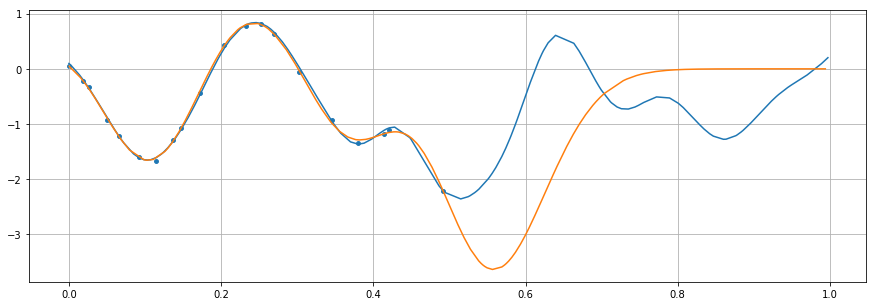

In [56]:
plt.figure(figsize=(15, 5))
#plt.plot(X0_l.ravel(), f[:n_l], color='gray')
#plt.scatter(X0_l.ravel(), y[:n_l], s=5, color='gray')
#plt.plot(X0_h.ravel(), f[n_l:])
#plt.scatter(X0_h.ravel(), y[n_l:], s=15)
plt.plot(X0_h.ravel(), f[n_l:])
plt.scatter(X0_h[:100:5], y[n_l:n_l+100:5], s=15)

plt.grid()

plt.plot(X0_l.ravel(), preds)

In [57]:
import mfgpr

In [58]:
mfgpr = mfgpr.GaussianProcessCoKriging(
            kernel=composite_kernel,
            n_restarts_optimizer=3
        )

In [59]:
mfgpr.fit(X0_l[::5], y[:n_l:5], X0_h[:100:5], y[n_l:n_l+100:5])

GaussianProcessCoKriging(alpha=1e-10, eval_gradient=False,
                         kernel=WhiteKernel(noise_level=1) + 1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=3, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None,
                         rho=0.6534253742685425, rho_bounds=(-1, 1))

In [60]:
mfgpr

GaussianProcessCoKriging(alpha=1e-10, eval_gradient=False,
                         kernel=WhiteKernel(noise_level=1) + 1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=3, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None,
                         rho=0.6534253742685425, rho_bounds=(-1, 1))

In [61]:
mfgpr.kernel_d_

WhiteKernel(noise_level=0.001) + 0.58**2 * RBF(length_scale=1.43)

In [62]:
mfgpr.kernel_l_

WhiteKernel(noise_level=0.0238) + 1.44**2 * RBF(length_scale=0.0646)

In [63]:
mfgpr.rho

0.6534253742685425

In [64]:
mfpreds = mfgpr.predict(X0_l)

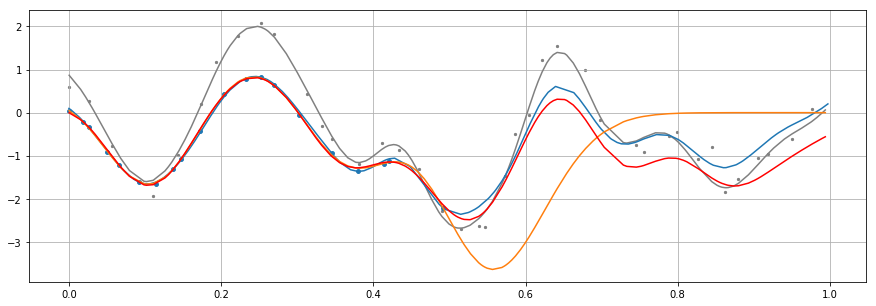

In [65]:
plt.figure(figsize=(15, 5))
plt.plot(X0_l.ravel(), f[:n_l], color='gray')
plt.scatter(X0_l[::5].ravel(), y[:n_l:5], s=5, color='gray')
plt.plot(X0_h.ravel(), f[n_l:])
plt.scatter(X0_h[:100:5].ravel(), y[n_l:n_l+100:5], s=15)
plt.grid()

plt.plot(X0_l.ravel(), preds)
plt.plot(X0_l.ravel(), mfpreds, color='r')

# Trash